# [IAPR][iapr]: Lab 1 ‒  Image segmentation


**Group ID:** 14

**Author 1 (sciper):** Emna Tourki (288580)  
**Author 2 (sciper):** Yu-Hsin Yang (334949)   
**Author 3 (sciper):** Tabea Steinbrinker (350566)   

**Release date:** 11.03.2022
**Due date:** 25.03.2022 (11:59 pm)


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as
preparation for the final project, which is a practical project which ties together the topics of the course.

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external
functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation
in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook <font color='red'> rerun </font>the notebook from scratch !**
`Kernel` > `Restart & Run All`

We will not rerun the notebook for you.

[iapr]: https://github.com/LTS5/iapr

---
## 0. Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')

if not os.path.exists(tar_path):
    raise Exception('Path to is not valid {}'.format(tar_path))
    
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

In [2]:
import numpy as np
from skimage import measure, filters
from skimage.segmentation import flood, flood_fill
import cv2

---
## Part 1: Brain segmentation

Your goal: compute the size of the brain (without the skull) in pixels in a 2D image of a human head taken by
Magnetic Resonance Imaging (MRI) using:
* Region growing (5 pts)
* Contour detection (5 pts)
* An additional method of your choice (5 pts)

Each section should display the resulting segmentation as well as the size in pixel of the detected region. Comment
each method limitations and/or advantages.

### 1.1 Brain image visualization

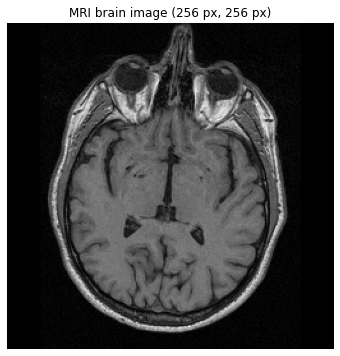

In [3]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

# Display MRI image
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

### 1.2 Region growing (5pts)

In [4]:
# Add your implementation and discussion

Algorithm for Region growing:
* Fix a starting point
* define the homogeneity criterion used to define the region
* include all the neighboring pixels, that satisfy the homogeneity criterion.

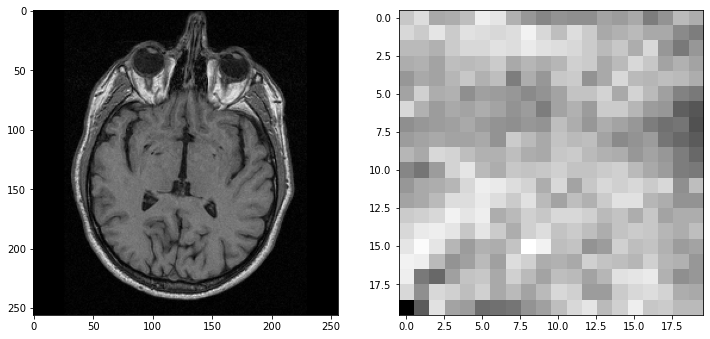

In [5]:
#Find a criterion (i.e. find a threshold)
# We find the minimum and maxmum value in a certain (ramdom) field in the brain and use it as threshhold
brain_im_small = brain_im[100:120,100:120]

fig, ax = plt.subplots(1, 2, figsize=(12, 7))
ax[0].imshow(brain_im, cmap='gray')
ax[1].imshow(brain_im_small, cmap='gray')
plt.show()

In [6]:
print(np.min(brain_im_small),np.max(brain_im_small))


34 93


In [7]:
def region_growing(im, x,y, thresh_low,thresh_high):
    '''takes an image and a starting point and grows the region that sits inbetween the threshhold.
    returns a mask with true values in the segmentation'''
    
    eightneig = [(-1,-1),(0,-1),(-1,0),(1,0),(0,1),(-1,1),(1,-1),(1,1)]
    
    seg = np.zeros(shape = im.shape, dtype = np.uint8)
    visited = np.zeros(shape = im.shape, dtype = np.uint8)
    
    seg[x][y] = 1
    
    seeds = [(x,y)]
    
    
    while len(seeds):
        seed = seeds.pop(0)
        x = seed[0]
        y = seed[1]
        
        visited[x][y] = 1
        for direct in eightneig:
            cur_x = x + direct[0]
            cur_y = y + direct[1]
            #print(f'visited of current point = {visited[cur_x][cur_y]}, and the image value = {im[cur_x,cur_y]}')
            if cur_x < 0 or cur_y < 0 or cur_y > im.shape[1] or cur_x > im.shape[0]:
                continue
            if visited[cur_x][cur_y]==0 and (thresh_low <= im[cur_x,cur_y] <= thresh_high):
                #print(f'cur_x = {cur_x} and cur_y = {cur_y}')
                seg[cur_x][cur_y] = 1
                visited[cur_x][cur_y] = 1
                seeds.append((cur_x,cur_y))
    
    return(seg)

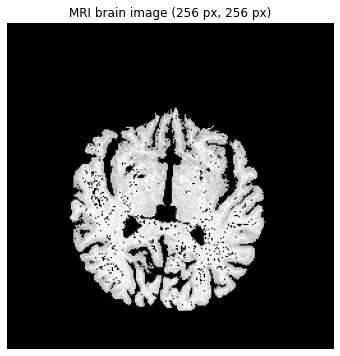

In [8]:
mask = region_growing(brain_im,100,100,60,90)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im*mask, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

As we see some black points, we will put the threshhold a little bit higher.

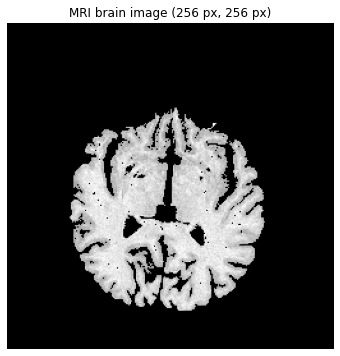

In [9]:
mask = region_growing(brain_im,100,100,60,95)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im*mask, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

To sum up the pixels in the brain, we sum up the ones in our segmentatioin matrix:

In [10]:
print(f'The number of pixels in the brain is:', np.sum(mask))

The number of pixels in the brain is: 15354


#### Advanteges of the method:
- Easily
- Doesn't need to find a contour
- It should be very fast, only go through the neighbors once.

#### Disadvantages of the method:
- We find great differences in our region if we the change the threshhold a little bit
- Also, the threshhold is very perticular for this special image and must not be applyable to other images (other MRI images of brains)

### 1.3 Contour detection (5pts)

In [11]:
# Add your implementation and discussion

First, we find a mask for image values between 60 and 95, selected as already in 1.2

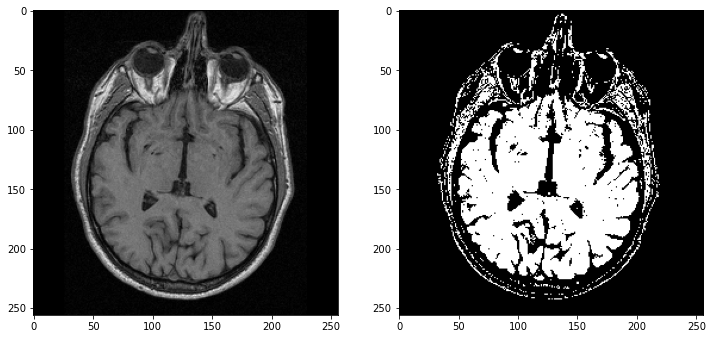

In [12]:
mask_brain=(brain_im>60)&(brain_im<95)
not_brain=np.logical_not(mask_brain)

new_im_brain = np.copy(brain_im)
new_im_brain[mask_brain] = 255
new_im_brain[not_brain] = 0
fig, ax = plt.subplots(1, 2, figsize=(12, 7))
ax[0].imshow(brain_im, cmap='gray')
ax[1].imshow(new_im_brain, cmap='gray')
plt.show()

Then we find the contours on this image, using the skimage package.
As we found a great amount of Contours, we chose the ones that contourd our brain. We did this, by looking at the length of the contours and selecting the ones, with the greatest length.
We also chose a starting point, from were we will fill our contour in order to obtain a mask.

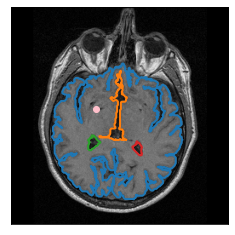

In [13]:
contours = measure.find_contours(new_im_brain, 60)

#make a list of the longest 10 contours and their indices in the list contours
list_shapes = [[contour.shape[0],i] for i,contour in enumerate(contours)]
sortet_list = sorted(list_shapes,key=lambda x: x[0])[:-20:-1]
sortet_list = [int(x[1]) for x in sortet_list]

# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(brain_im, cmap=plt.cm.gray)

for i,contour in enumerate(contours):
    if i in [197,257,524,503]:
        ax.plot(contour[:, 1], contour[:, 0], linewidth=2,label = {i})
    
ax.scatter(100,120,color = 'pink')

#plt.legend()
ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [14]:
def contours_filling(im, x,y, contours):
    '''takes an image and a starting point nd grows the region that sitzs inbetween the threshhold.
    returns a mask with true values in the segmentation'''
    
    fourneig = [(0,-1),(-1,0),(1,0),(0,1)]
    
    seg = np.zeros(shape = im.shape, dtype = np.uint8)
    visited = np.zeros(shape = im.shape, dtype = np.uint8)
    
    seg[x][y] = 1
    
    seeds = [(x,y)]
    
    
    while len(seeds):
        seed = seeds.pop(0)
        x = seed[0]
        y = seed[1]
        
        visited[x][y] = 1
        for direct in fourneig:
            cur_x = x + direct[0]
            cur_y = y + direct[1]
            #print(f'visited of current point = {visited[cur_x][cur_y]}, and if it is in contours: = {[cur_x,cur_y] in contours}')
            if cur_x < 0 or cur_y < 0 or cur_y >= im.shape[1] or cur_x >= im.shape[0]:
                continue
            if visited[cur_x][cur_y]==0 and any(np.equal(int_rel_contours,[cur_x,cur_y]).all(1))==False:
                #print(f'cur_x = {cur_x} and cur_y = {cur_y}')
                seg[cur_x][cur_y] = 1
                visited[cur_x][cur_y] = 1
                seeds.append((cur_x,cur_y))
    
    return(seg)

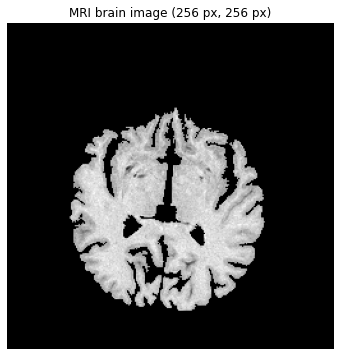

In [15]:
int_rel_contours = np.around(np.concatenate((contours[197],contours[257],contours[524],contours[503])))
mask = contours_filling(brain_im,100,120,int_rel_contours)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im*mask, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

With the function contour_filling we found a mask, that is one inside our contours and zero outside. As we can see, this gives us the region of the brain in the image. By summing up als the ones in the mask we find the number of pixels.

In [16]:
print('The number of pixels in the brain is:',np.sum(mask))

The number of pixels in the brain is: 15462


#### Advanteges of the method:
- This algorithm is more robust than the region growing method.
- Doesn't depend on the intensity

#### Disadvantages of the method:
- The algorithm finds out so many contour. We need extra effort to filter out the real contour we need.
- This algorithm won't work perfectly if there is some noise in the picture.


### 1.4 Additional method (5pts)

We find an additional method using the skimage segmentation method called flood fill.  
This algorithm works by filling or recolouring a selected area containing different colours at the inside portion and therefore the boundary of the image.   
To paint such regions we will replace a specific interior colour instead of discovering a boundary colour value.  

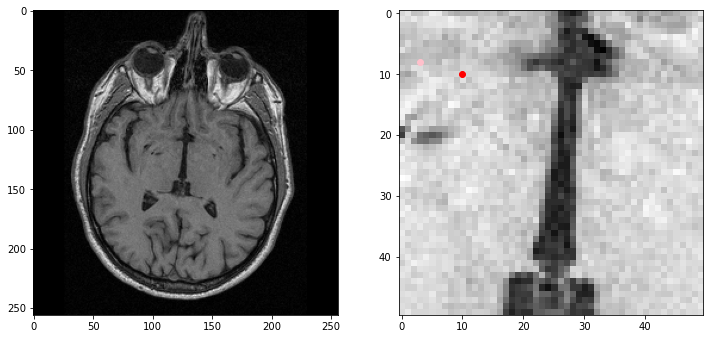

In [17]:
#Find a starting point inside the brain
#We need a point that is not too dark and not too light
brain_im_small = brain_im[100:150,100:150]


fig, ax = plt.subplots(1, 2, figsize=(12, 7))

ax[0].imshow(brain_im, cmap='gray')
ax[1].imshow(brain_im_small, cmap='gray')
ax[1].scatter(10,10,color = 'red')
ax[1].scatter(3,8,color = 'pink')
plt.show()

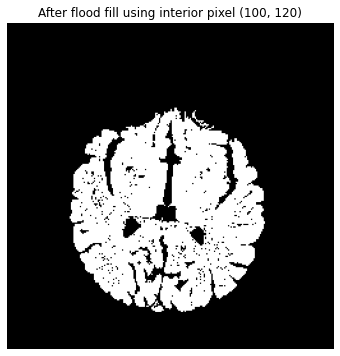

In [18]:
light_brain = flood_fill(brain_im, (100, 120), 255, tolerance=18)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

# Create a mask 
light_brain[light_brain < 255] = 0

ax.imshow(light_brain, cmap=plt.cm.gray)
#ax.plot(100, 120, 'ro')  # seed point
ax.set_title('After flood fill using interior pixel (100, 120)')
ax.axis('off')

plt.show()

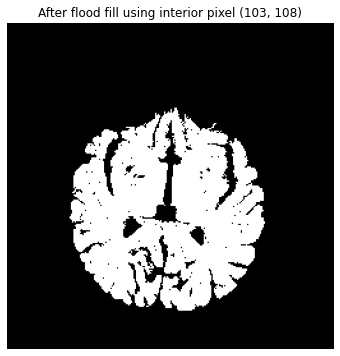

In [19]:
light_brain = flood_fill(brain_im, (103, 108), 255, tolerance=18)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

# Create a mask 
light_brain[light_brain < 255] = 0

ax.imshow(light_brain, cmap=plt.cm.gray)
#ax.plot(100, 120, 'ro')  # seed point
ax.set_title('After flood fill using interior pixel (103, 108)')
ax.axis('off')

plt.show()

To sum up the pixels in the brain, we sum up the 255s in our light_brain matrix:

In [20]:
print(f'The number of pixels in the brain is:', int(np.sum(light_brain)/255))

The number of pixels in the brain is: 15609


#### Advanteges of the method:
- It can process the image containing more than one boundary colours.
- More efficient.

#### Disadvantages of the method:
- The starting pixel needs to be selected carefully, or the result can be quite different. (Reference to the above two pictures. The first plot has more holes than the second one, which means that the starting pixel in the second plot has value that is more similar to the whole brain image.)

#### Conclusion:
We see, that all three versions output a very similar number of pixels, and also a very similar mask.

---
## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different
colors. We ask you to create a routine to:

1. Count the number of shapes of each color (5pts).
2. Compute the total area (in pixels) of each color (5pts).

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity
normalization should probably be used.

hint: RGB color space might not be optimal. Consider using HSV or LAB color space.

### 2.1 Visualization

In [21]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

Number of images:  3
Image size: 480, 640 
Number of color channels:  3


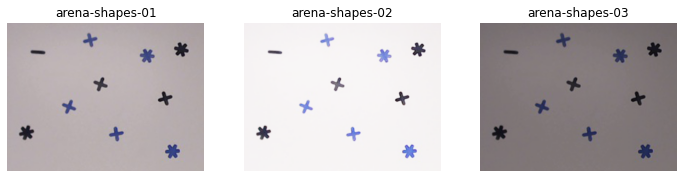

In [22]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Number of shapes of each color (5 pts)

We used the LAB color space

In [23]:
def print_RGB2LAB_image(img):
    #convert to LAB color space
    im_LAB = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    
    #plot the 3 channels and their respective histogram of intensities
    fig, axes = plt.subplots(2, 3)
    fig.set_size_inches(18.5, 10.5)
    axes[0,0].imshow(im_LAB[:,:,0]) #HSV format
    axes[0,0].set_title("L")
    axes[0,1].imshow(im_LAB[:,:,1])
    axes[0,1].set_title("a")
    axes[0,2].imshow(im_LAB[:,:,2])
    axes[0,2].set_title("b")
    axes[1,0].hist(im_LAB[:,:,0].ravel())
    axes[1,0].set_title("L hist")
    axes[1,1].hist(im_LAB[:,:,1].ravel())
    axes[1,1].set_title("a hist")
    axes[1,2].hist(im_LAB[:,:,2].ravel())
    axes[1,2].set_title("b hist")
    return im_LAB

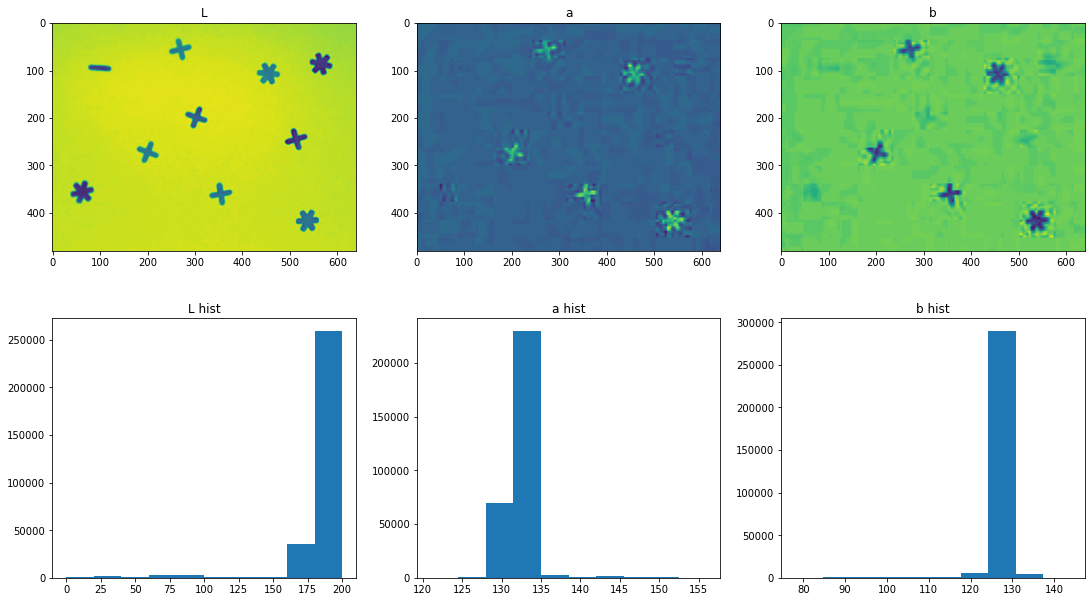

In [24]:
im_LAB0=print_RGB2LAB_image(images[0])

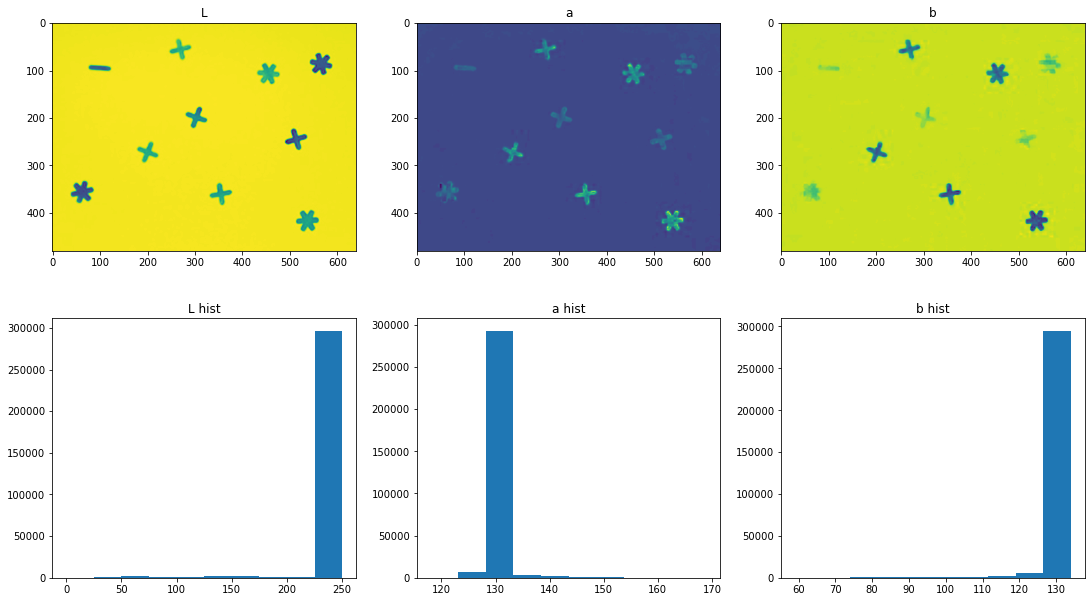

In [25]:
im_LAB1=print_RGB2LAB_image(images[1])

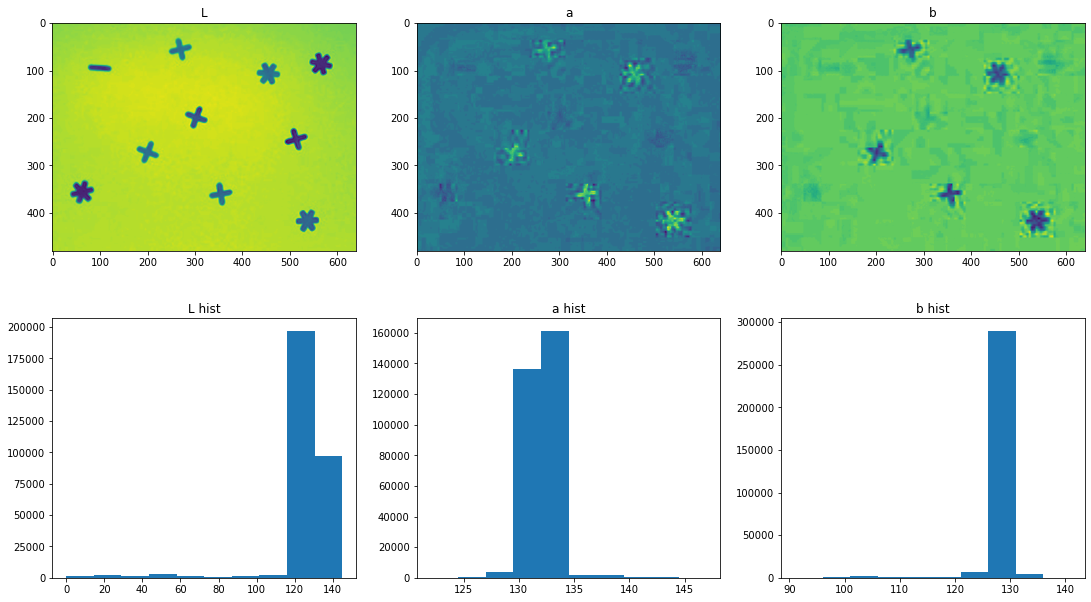

In [26]:
im_LAB2=print_RGB2LAB_image(images[2])

- From the images above we can see that with the **channel L** we can differentiate between the background and all shapes.  
- Then with the **channel b** we can extract the shapes in blue which have a lower intensity value than the rest of the pixels in the image of channel b.  
- Assuming we have only two colors, the shapes that are in the first image of shapes but not visible in the image of the channel b are the ones of the second color.
- For the threshold we used **Otsu's thresholding** so that the threashold is chosen automatically and our code is robust to illumination changes.

In [27]:
def bin_mask(im_LAB):
    #initialisation
    bin_shape = np.zeros(im_LAB.shape[0:2])
    bin_color1=np.zeros(im_LAB.shape[0:2])
    bin_color2=np.zeros(im_LAB.shape[0:2])
    # mask of the shapes
    bin_shape[ (im_LAB[:,:,0]<filters.threshold_otsu(im_LAB[:,:,0]))] = 255
    #extract the shapes of the first color
    bin_color1[(bin_shape[:]==255) & (im_LAB[:,:,2]<cv2.threshold(im_LAB[:,:,2],0,255,cv2.THRESH_OTSU)[0]) ]= 255
    #extract the shapes of the second color
    bin_color2[(bin_shape[:]==255) & (im_LAB[:,:,2]>cv2.threshold(im_LAB[:,:,2],0,255,cv2.THRESH_OTSU)[0])] = 255
    
    return bin_shape,bin_color1,bin_color2

Text(0.5, 1.0, 'mask color 2')

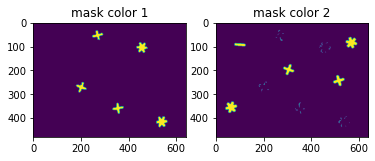

In [28]:
#Let's have a look using image 0
bin_shape,bin_color1,bin_color2=bin_mask(im_LAB0)
fig, axes = plt.subplots(1,2)
axes[0].imshow(bin_color1)
axes[0].set_title("mask color 1")
axes[1].imshow(bin_color2)
axes[1].set_title("mask color 2")


We can see that we have some noise in the 2nd mask.  
The function remove_noise is used to remove from the mask the scattered pixels that are not part of any shape.  

In [29]:
def remove_noise(bin_img,min_pix):
    #labels is a Labeled array the same size of the image bin_img where all connected regions are assigned the same integer value.
    labels = measure.label(bin_img)
    img_new = np.copy(bin_img)
    #num_comp is the number of connected region
    num_comp = np.amax(labels)
    
    for i in range(num_comp+1):
        num_pixels = sum(sum(labels==i))
        #remove the connected region where there is less that min_pix pixels
        if num_pixels < min_pix:
            img_new[labels==i] = 0
    
    return img_new

In [30]:
def color_mask(image_original,image_LAB):
    bin_shape,bin_color1,bin_color2=bin_mask(image_LAB)
    # The mask of color 1 is noiseless so we didn't display the original image which is identical to the one w/o noise for a better display
    bin_color1=remove_noise(bin_color1,100)
    bin_color2_wonoise=remove_noise(bin_color2,100)
    
    #plot
    fig, axes = plt.subplots(2,3)
    fig.set_size_inches(18.5, 10.5)
    axes[0,0].imshow(image_original)
    axes[0,0].set_title("original")
    axes[0,2].imshow(bin_shape)
    axes[0,2].set_title("bin_shape")
    axes[0,1].imshow(im_LAB0)
    axes[0,1].set_title("image_LAB format")
    axes[1,0].imshow(bin_color1)
    axes[1,0].set_title("bin_color1")
    axes[1,1].imshow(bin_color2)
    axes[1,1].set_title("bin_color2")
    axes[1,2].imshow(bin_color2_wonoise)
    axes[1,2].set_title("bin_color2 w/o noise")
    return bin_shape,bin_color1,bin_color2_wonoise



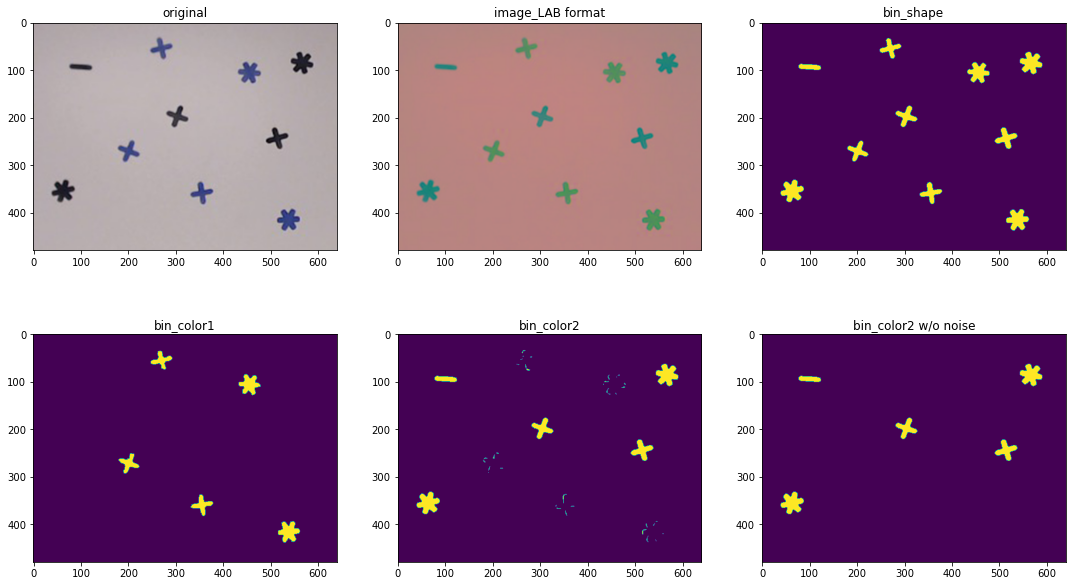

In [31]:
im0_bin_shape,im0_bin_color1,im0_bin_color2=color_mask(images[0],im_LAB0)

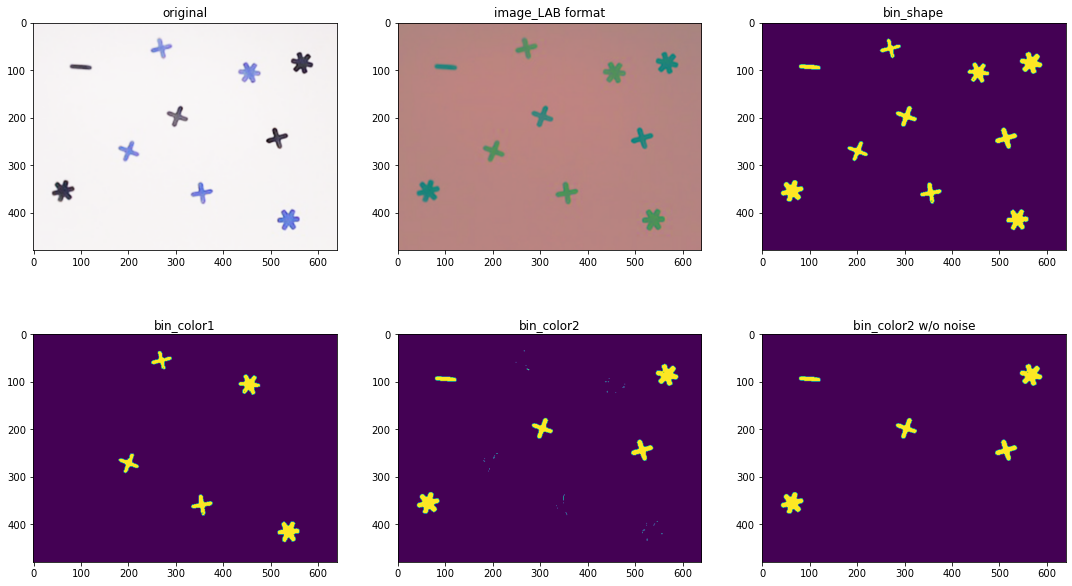

In [32]:
im1_bin_shape,im1_bin_color1,im1_bin_color2=color_mask(images[1],im_LAB1)

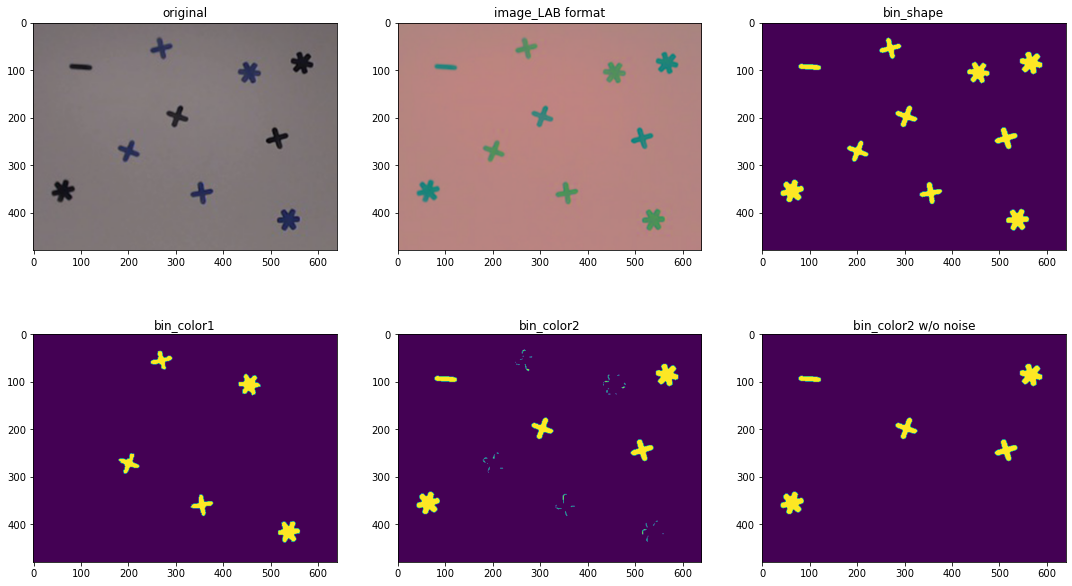

In [33]:
im2_bin_shape,im2_bin_color1,im2_bin_color2=color_mask(images[2],im_LAB2)

Then we wrote a function, that will find the nubmer of shapes, based on the length of their contours, as different shapes, have a very different contour length. We run this algorithm on the different bin_color images, where the colors have already been seperated.

In [34]:
def number_of_shapes(image):
    
    # find the contours of the image:
    contours = measure.find_contours(image, 120)

    contourlength = [contour.shape[0] for contour in contours if (contour.shape[0]>10) ]
    
    thresh = 12
    
    shapes = -np.ones(len(contourlength))
    ind = np.argsort(contourlength)
    acc = 0
    shapes[ind[0]] = acc
    for i in range(1,len(contourlength)):
        if contourlength[ind[i]]-contourlength[ind[i-1]]<thresh:
            shapes[ind[i]] = acc
        else:
            acc += 1
            shapes[ind[i]] = acc

    return int(max(shapes)+1)

In [35]:
print(f"For image arena-shapes-01, there are two colors,")
num = number_of_shapes(im0_bin_color1)
print(f"In color 0 there are {num} shapes")
num = number_of_shapes(im0_bin_color2)
print(f"In color 1 there are {num} shapes\n")


print(f"For image arena-shapes-02, there are two colors,")
num = number_of_shapes(im1_bin_color1)
print(f"In color 0 there are {num} shapes")
num = number_of_shapes(im1_bin_color2)
print(f"In color 1 there are {num} shapes\n")

print(f"For image arena-shapes-03, there are two colors,")
num = number_of_shapes(im2_bin_color1)
print(f"In color 0 there are {num} shapes")
num = number_of_shapes(im2_bin_color2)
print(f"In color 1 there are {num} shapes\n")

For image arena-shapes-01, there are two colors,
In color 0 there are 2 shapes
In color 1 there are 3 shapes

For image arena-shapes-02, there are two colors,
In color 0 there are 2 shapes
In color 1 there are 3 shapes

For image arena-shapes-03, there are two colors,
In color 0 there are 2 shapes
In color 1 there are 3 shapes



### 2.3 Total area (in pixels) of each color (5 pts)

In [36]:
print(f"For image arena-shapes-01, there are two colors,")
print("In color 0, there",  int(np.sum(im0_bin_color1)/255), "pixels")
print("In color 1, there",  int(np.sum(im0_bin_color2)/255), "pixels\n")

print(f"For image arena-shapes-02, there are two colors,")
print("In color 0, there",  int(np.sum(im1_bin_color1)/255), "pixels")
print("In color 1, there",  int(np.sum(im1_bin_color2)/255), "pixels\n")

print(f"For image arena-shapes-03, there are two colors,")
print("In color 0, there",  int(np.sum(im2_bin_color1)/255), "pixels")
print("In color 1, there",  int(np.sum(im2_bin_color2)/255), "pixels\n")

For image arena-shapes-01, there are two colors,
In color 0, there 4544 pixels
In color 1, there 4967 pixels

For image arena-shapes-02, there are two colors,
In color 0, there 4064 pixels
In color 1, there 4453 pixels

For image arena-shapes-03, there are two colors,
In color 0, there 4615 pixels
In color 1, there 5065 pixels



### Discussions
According to the above result, arena-shapes-01 and arena-shapes-03 have similar pixels in two color; while arena-shapes-02 has around 500 pixels less than other two images in both colors. We think that the result is due to the fact that arena-shapes-02 is lighter than other two images, which makes it harder to distinguish the background (white) from the objects. But from the fact, that our image has 480x640 = 307200 pixels, a difference of 500 pixels is not a very big difference.